In [2]:
import pandas as pd
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc as pm
import arviz as az
import pandas as pd
import scipy.linalg as la
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
az.style.use('arviz-darkgrid')
#os.chdir('/Users/noahdunn/Desktop/MSDS/DS6040/Project')

/Users/alseekford/opt/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
df = pd.read_csv('Use_This.csv')

In [4]:
df.head()

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,TOR,MIA,102,111,120,12.800000
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,TOR,MIA,101,81,122,12.800000
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,TOR,MIA,108,116,224,11.750000
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,TOR,WAS,83,98,1020,8.966667
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,TOR,BOS,115,83,1022,11.325000


In [5]:
df['10_game_average'] = df.groupby('player_id').fantasy_points.apply(lambda x: x.shift().rolling(10, min_periods=1).mean().fillna(x))

In [7]:
# Conditions
conditions = [
    (df['fantasy_points'] <= 0) & (df['avg_pts'] < 2),
    (df['fantasy_points'] > 0) & (df['fantasy_points'] < 3.3) & (df['avg_pts'] >= 2) & (df['avg_pts'] < 6.5),
    (df['fantasy_points'] >= 3.3) & (df['fantasy_points'] < 15.6) & (df['avg_pts'] >= 6.5) & (df['avg_pts'] < 16),
    (df['fantasy_points'] >= 15.6) & (df['fantasy_points'] < 27.5) & (df['avg_pts'] >= 16) & (df['avg_pts'] < 25), 
    (df['fantasy_points'] >= 27.5) & (df['fantasy_points'] < 100) & (df['avg_pts'] >= 25) & (df['avg_pts'] < 73)]

# Ranks
values = [0, 1, 2, 3, 4]

# Assign
df['rank'] = np.select(conditions, values)

In [9]:
df

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts,10_game_average,rank
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,TOR,MIA,102,111,120,12.800000,12.800000,2
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,TOR,MIA,101,81,122,12.800000,12.800000,2
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,TOR,MIA,108,116,224,11.750000,11.750000,2
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,TOR,WAS,83,98,1020,8.966667,8.966667,0
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,TOR,BOS,115,83,1022,11.325000,11.325000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30829,53979,202112200LAC,zubaciv01,1,27:21,0,0,31.9,Ivica Zubac,C,LAC,SAS,92,116,1220,20.970000,20.970000,0
30830,54290,202112220SAC,zubaciv01,1,26:39,0,0,22.2,Ivica Zubac,C,LAC,SAC,105,89,1222,23.180000,23.180000,3
30831,54770,202112260LAC,zubaciv01,1,27:22,0,0,36.2,Ivica Zubac,C,LAC,DEN,100,103,1226,22.760000,22.760000,0
30832,54968,202112270LAC,zubaciv01,1,21:45,0,0,19.3,Ivica Zubac,C,LAC,BRK,108,124,1227,24.130000,24.130000,3


In [39]:
rank

0        2
1        2
2        2
3        0
4        0
        ..
30829    0
30830    3
30831    0
30832    3
30833    3
Name: rank, Length: 30834, dtype: int64

# Testing out his Hierarchical Stuff

In [34]:
# Predictor variables
minutes = df['mp']
# normal
points = df['fantasy_points']
# normal
opponent = df['opponent']
# 
avgpoints = df['avg_pts']
# normal
starter = df['starter']
# bernoulli

rank = df['rank']
# 

# grouping or hierarchical variable
positions = df['position'].unique()
npositions = len(positions)

# lookup table (dict) for each district
position_lookup = dict(zip(positions, range(npositions)))
position  = df["position_code"] = df.position.replace(position_lookup).values

In [36]:
test = []
for i in minutes:
    j = i.split(':')
    secs = int(j[1])
    if secs > 30:
        ans = int(j[0])
    else:
        ans = int(j[0]) + 1
    test.append(ans)

In [37]:
test2 = pd.factorize(df['opponent'])[0]+1

In [40]:
with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
    
    # Linear model
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    
    # Transform outcome to probability
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=d, sigma=sigma_d, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)

Only 250 samples in chain.


ValueError: Input dimension mismatch. One other input has shape[0] = 30834, but input[4].shape[0] = 7.
Apply node that caused the error: Elemwise{Composite{Switch(i0, ((i1 + (i2 * sqr(((i3 - i4) / i5)))) - i6), i7)}}(Elemwise{gt,no_inplace}.0, TensorConstant{(1,) of -0..5332046727}, TensorConstant{(1,) of -0.5}, y_hat{[12.8 10.7..19.3 19.3]}, d, InplaceDimShuffle{x}.0, Elemwise{log,no_inplace}.0, TensorConstant{(1,) of -inf})
Toposort index: 32
Inputs types: [TensorType(bool, (1,)), TensorType(float64, (1,)), TensorType(float64, (1,)), TensorType(float64, (30834,)), TensorType(float64, (None,)), TensorType(float64, (1,)), TensorType(float64, (1,)), TensorType(float32, (1,))]
Inputs shapes: [(1,), (1,), (1,), (30834,), (7,), (1,), (1,), (1,)]
Inputs strides: [(1,), (8,), (8,), (8,), (8,), (8,), (8,), (4,)]
Inputs values: [array([ True]), array([-0.91893853]), array([-0.5]), 'not shown', 'not shown', array([100000.]), array([11.51292546]), array([-inf], dtype=float32)]
Outputs clients: [[Sum{acc_dtype=float64}(sigma > 0)]]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [26]:
# Variational inference with ADVI optimization
advi_hierarchical_fit = pm.fit(50000, method='advi', model = hierarchical_model)

Finished [100%]: Average Loss = 1.3105e+05


In [ ]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_model)

In [ ]:
az.plot_trace(hierarchical_trace, var_names=['position', 'minutes', 'opponent', 'avgpoints', 'starter'], compact =True)

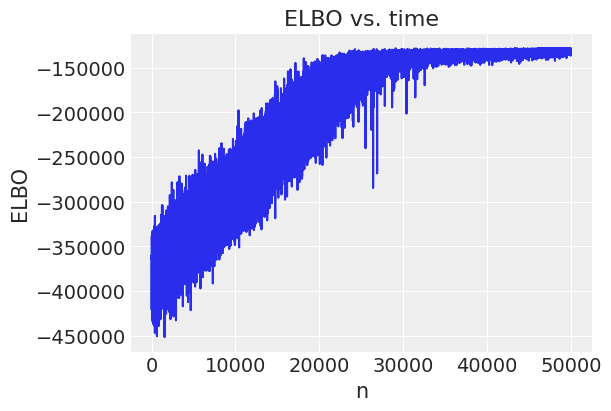

In [29]:
# plot the ELBO vs. fitting time or iterations (n)
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_hierarchical_fit.hist,
     'n': np.arange(advi_hierarchical_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()